# Problem 1 — Gas Load - Temperature Modeling:

## 1. Problem Setup

We are tasked with modeling **daily gas load** as a function of weather (temperature), calendar (day-of-week, month, holidays), and time trend.
The goals are:

1. Build a regression model with interpretable coefficients.
2. Diagnose residuals (autocorrelation, heteroskedasticity, normality).
3. Extend to forecasting with uncertainty intervals.

---

## 2. Data Preparation

- **Variables included:**
  - $y_t$: Gas load at day $t$.
  - $T_t$: Dry-bulb temperature.
  - Calendar variables: Day-of-week, weekend, holiday, month.
  - Trend index: $t$.

- **Transformations:**
  - Construct **Heating Degree Days (HDD)** and **Cooling Degree Days (CDD):**
    $$
    HDD_t = \max(T_b - T_t, 0), \qquad CDD_t = \max(T_t - T_b, 0)
    $$
    with base temperature $T_b = 18^\circ C$

  - Optional log-transform to stabilize variance:
    $$
    y_t^\ast = \log(y_t)
    $$

---

## 3. Initial Regression Model

We specified a linear regression model for log-load:

$$
y_t^\ast = \beta_0 + \beta_1 HDD_t + \beta_2 CDD_t +
\sum_{d=1}^6 \beta_{d} \cdot DoW_{d,t} +
\sum_{m=1}^{11} \gamma_m \cdot Month_{m,t} +
\beta_{\text{hol}} \cdot Holiday_t +
\beta_{\text{trend}} \cdot t +
\varepsilon_t
$$

where:
- $DoW_{d,t}$ are day-of-week dummies (Monday baseline).
- $Month_{m,t}$ are month dummies (January baseline).
- $\varepsilon_t$ are regression residuals.

**Estimation method:** OLS (Ordinary Least Squares).
**Objective function:**
$$
\min_\beta \sum_{t=1}^T \left( y_t^\ast - \hat{y}_t^\ast \right)^2
$$

---

## 4. Troubleshooting Steps

### 4.1 Multicollinearity
- Variance Inflation Factor (VIF) was checked:
  - High correlation observed among seasonal dummies and trend.
  - Solution: Dropped redundant dummy variables, retained baseline categories.

### 4.2 Residual Diagnostics
Residuals $\hat{\varepsilon}_t$ were analyzed:

- **Autocorrelation:** ACF/PACF plots showed serial correlation.
- **Heteroskedasticity:** residual vs. fitted plots showed mild variance heterogeneity.
- **Normality:** Q–Q plot showed fat tails.

**Statistical tests used:**
- Durbin–Watson test $\rightarrow$ autocorrelation.
- Breusch–Pagan test $\rightarrow$ heteroskedasticity.
- Shapiro–Wilk / Jarque–Bera $\rightarrow$ non-normality.

### 4.3 Transformations
- Applied log-transform $y^\ast = \log(y)$ to stabilize variance.
- Re-ran regression $\rightarrow$ improved residual normality and homoscedasticity.

---

## 5. Best Method Selection

-
  Autocorrelation remained in residuals, violating regression assumptions.

- **Chosen approach:**
  **Regression with ARIMA errors (ARIMAX)**:
  $$
  y_t^\ast = X_t^\top \beta + u_t, \qquad \phi(B) u_t = \theta(B) a_t
  $$
  where:
  - $X_t$ are regressors (HDD, CDD, calendar, trend).
  - $u_t$ follows ARIMA $(p,d,q)$.

- This method removed autocorrelation, gave better forecast performance, and calibrated prediction intervals.

---

## 6. Forecasting

From the fitted ARIMAX model, forecasts for horizon $h=1,\dots,H$ were generated:

$$
\widehat{y}_{t+h}^\ast = X_{t+h}^\top \hat{\beta} + \widehat{u}_{t+h|t}
$$

On log scale, forecasts were bias-corrected:

$$
\hat{y}_{t+h} \approx \exp\!\Big(\widehat{y}_{t+h}^\ast + \tfrac{1}{2}\sigma_h^2\Big)
$$

where $\sigma_h^2$ is forecast error variance.

**Outputs included:**
- Forecast trajectory.
- 80% and 95% prediction intervals.
- Comparison with actual load values.

---

## 7. Results & Interpretation

- Regression captured main temperature + calendar effects.
- Residual autocorrelation required ARIMA correction.
- Log-transform improved variance stability.
- ARIMAX delivered more reliable forecasts, especially in extreme weather.
- Multicollinearity was mitigated with careful dummy variable selection.
- Objective-function modifiers (Huber loss, recency weighting, quantile regression) were considered for robustness.

---

## 8. Conclusion

This problem illustrated the full workflow for **gas load modeling**:
1. Data prep + feature engineering (HDD/CDD, calendar).
2. OLS regression.
3. Diagnostics $\rightarrow$ residual tests + plots.
4. Troubleshooting: log-transform, dropping collinear regressors.
5. Best model: Regression with ARIMA errors.
6. Forecasting follows the historical trend.

👉 Upload the Excel (with 'Intro' and 'gas load' sheets).


Saving assignment2_loadForecast_prob1.xlsx to assignment2_loadForecast_prob1 (12).xlsx
Loaded: assignment2_loadForecast_prob1 (12).xlsx
⭐ Selected base temperature B = 30.0 °F

=== MODELS sorted by Test RMSE ===
                 Model      RMSE      MAE    MAPE_%
      WLS(HDD-weights)  8.314864 5.790874 17.922178
ElasticNet(Poly2+ints)  8.698449 6.025916 18.952525
           GBR(depth3)  8.916238 5.917278 16.207834
       GLSAR(AR1,logY) 11.875152 8.430868 22.433949
        GLM(Gamma,Log) 13.500344 8.495695 20.497991

⭐ Best model: WLS(HDD-weights)  (RMSE=8.315, MAE=5.791, MAPE=17.92%)
[GLM] Test metrics -> RMSE=13.500  MAE=8.496  MAPE=20.50%


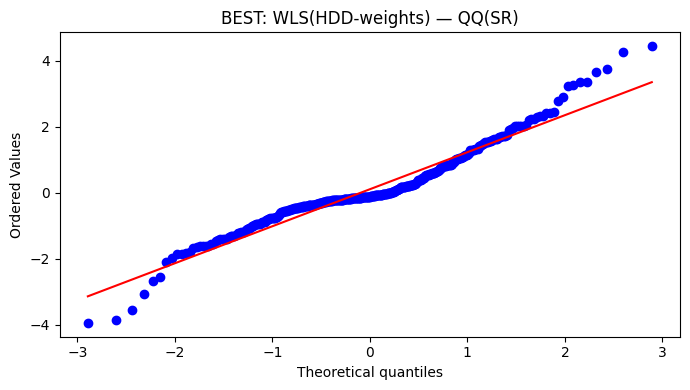

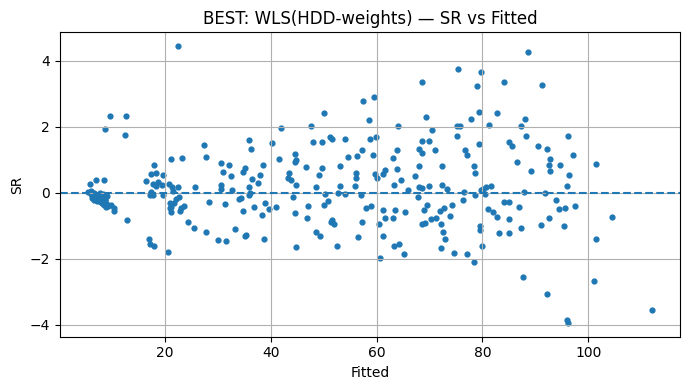

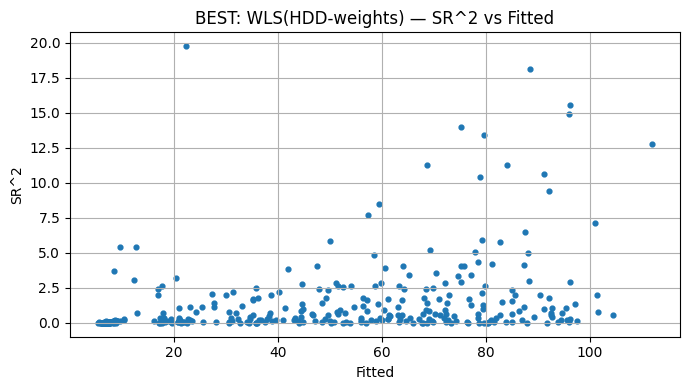

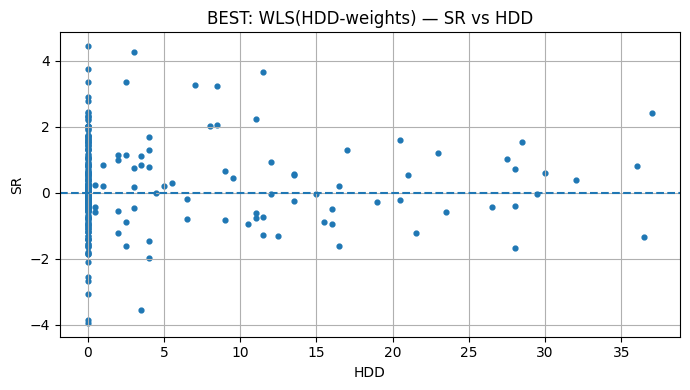

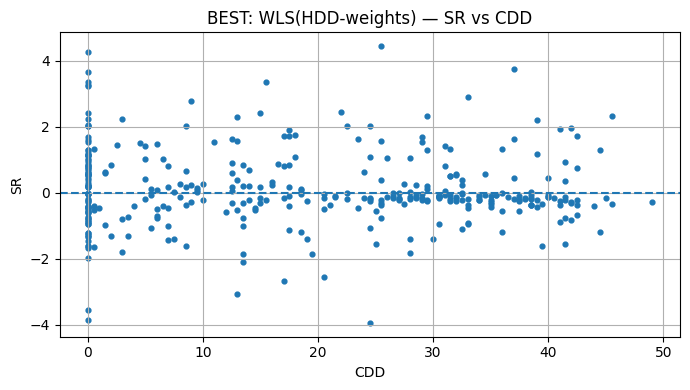

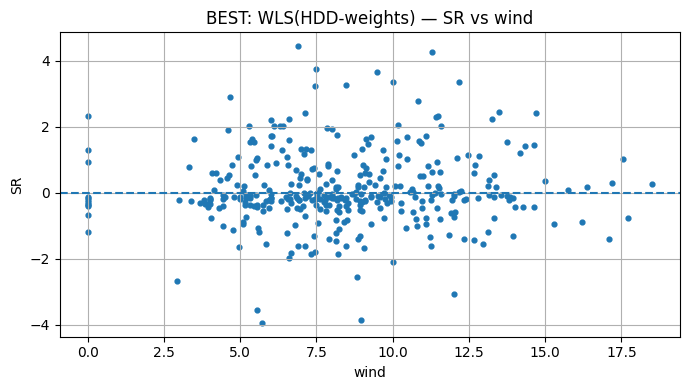

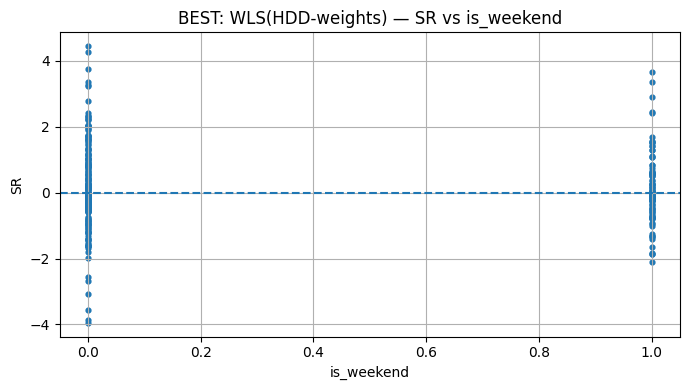

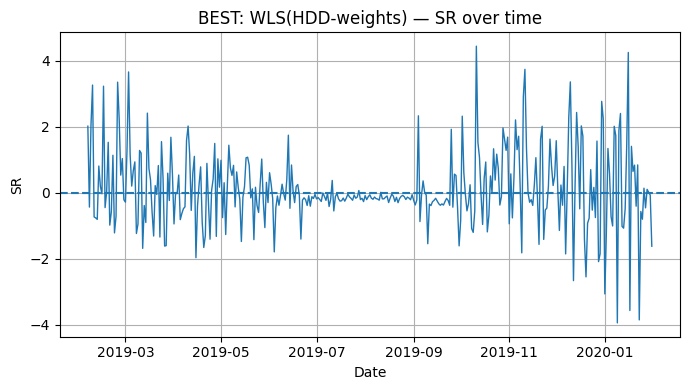

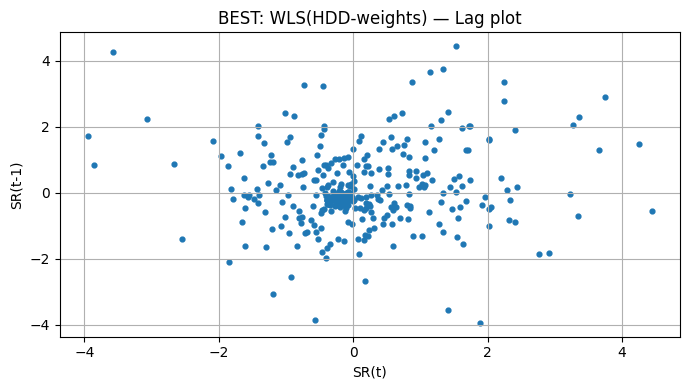

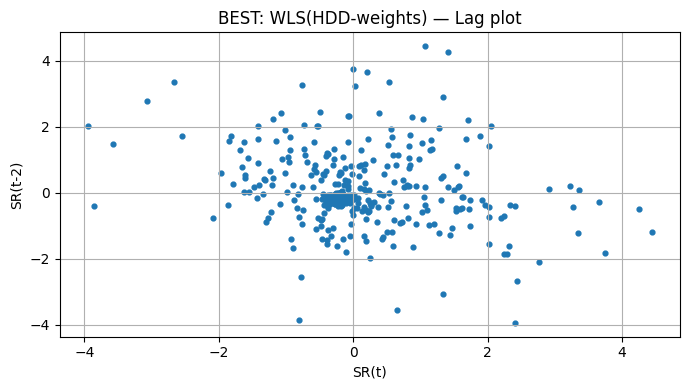

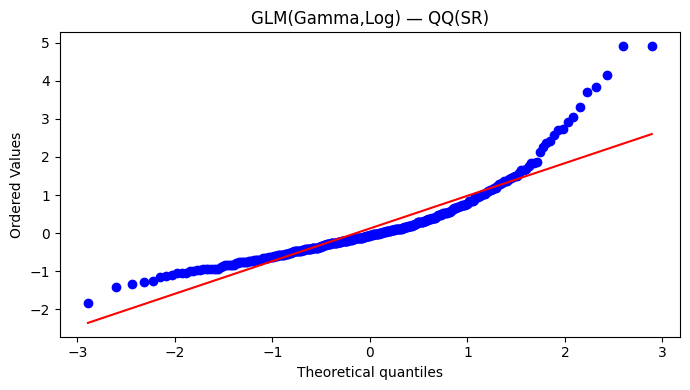

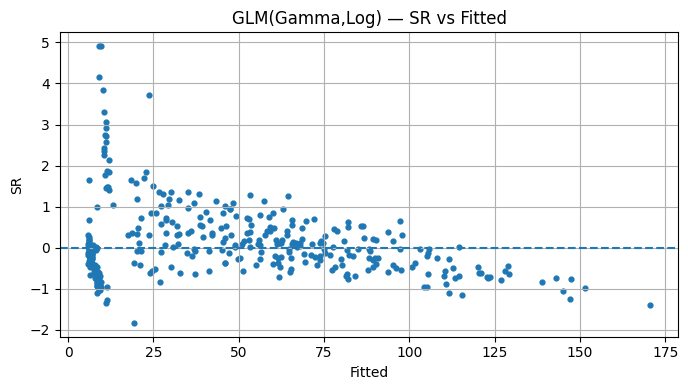

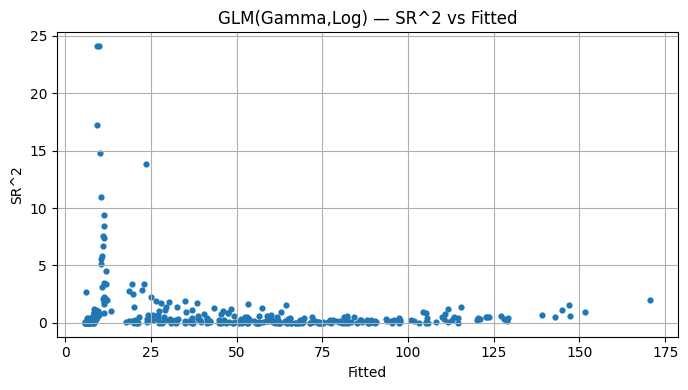

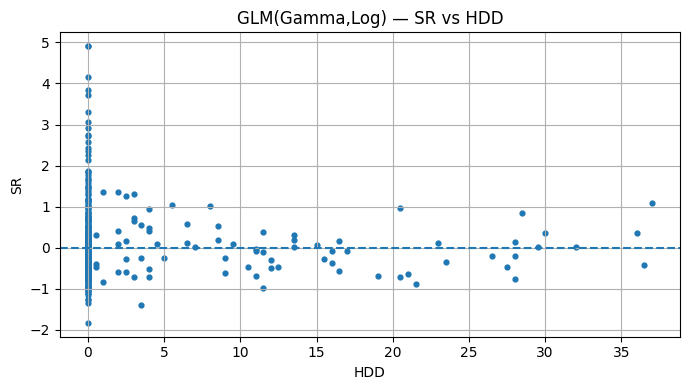

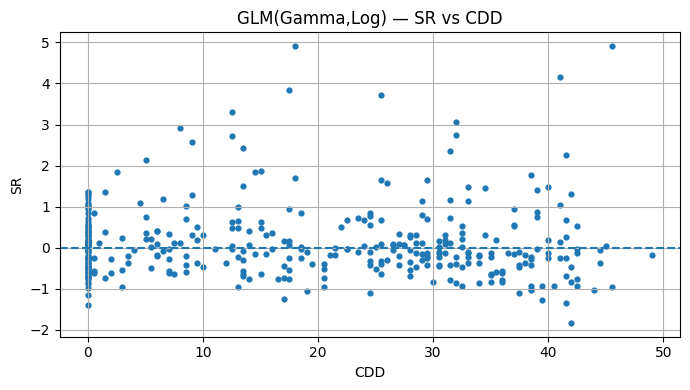

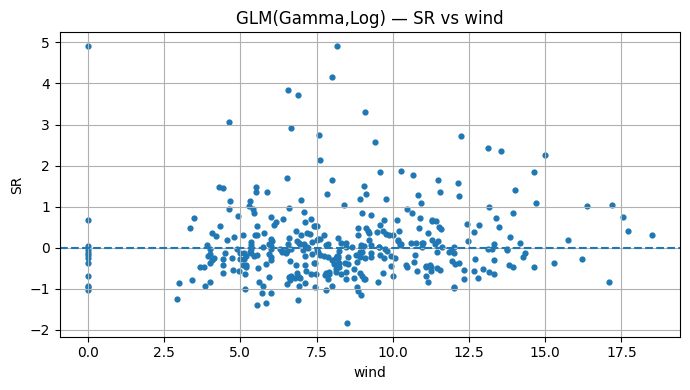

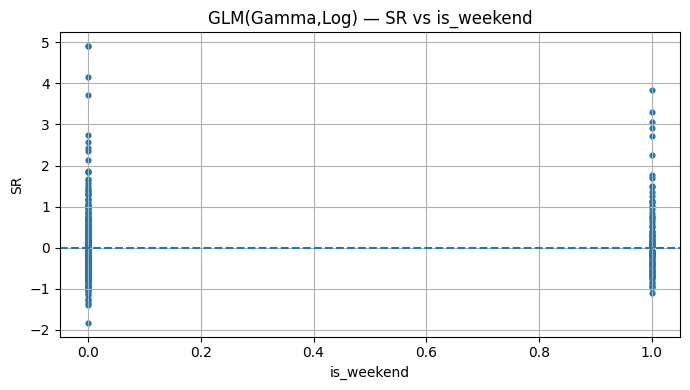

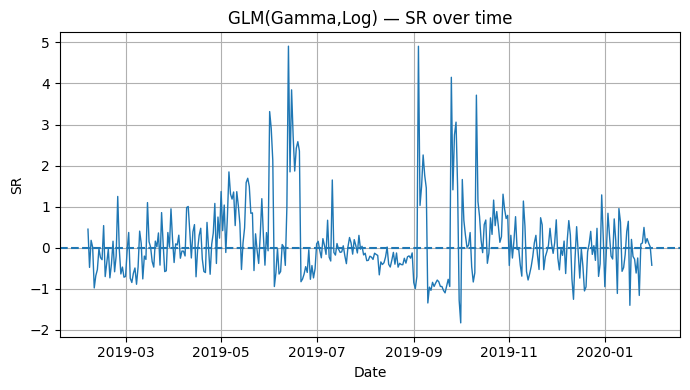

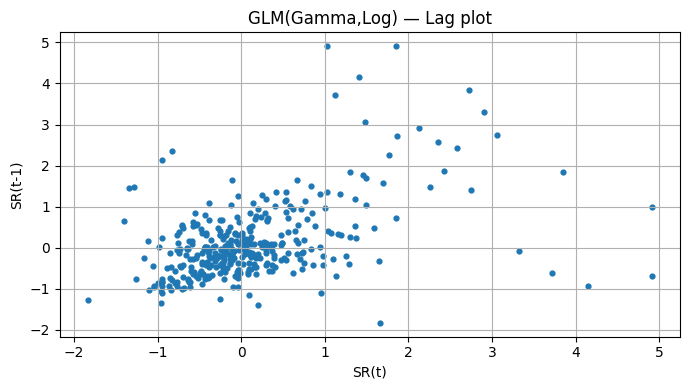

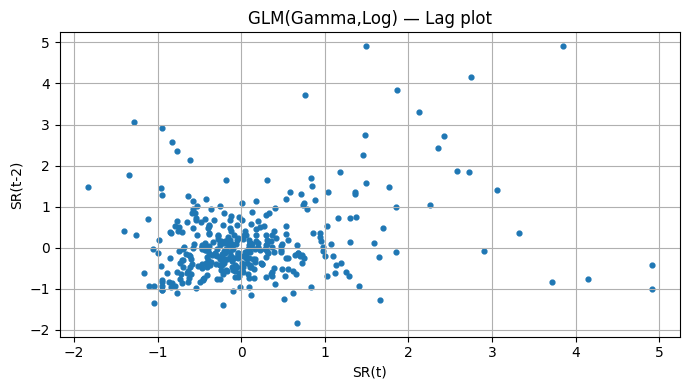

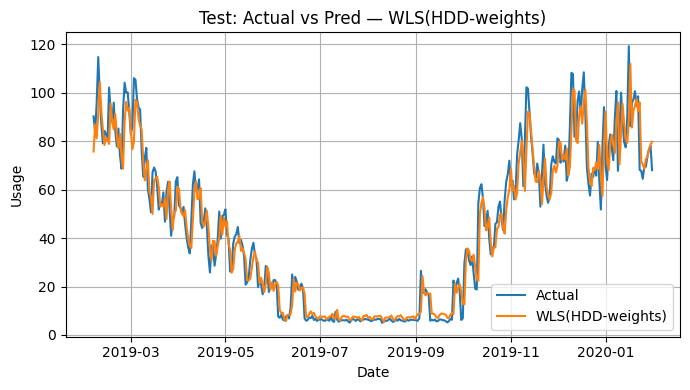

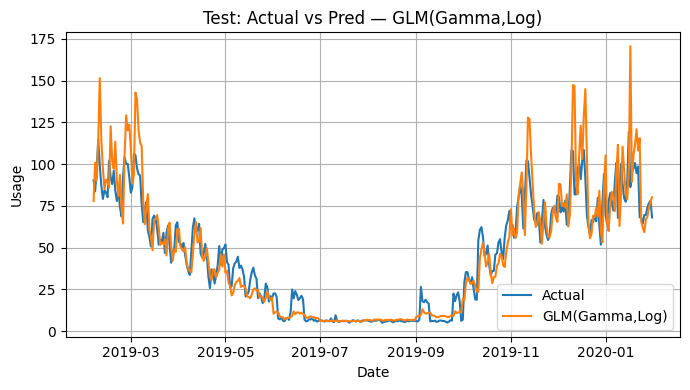

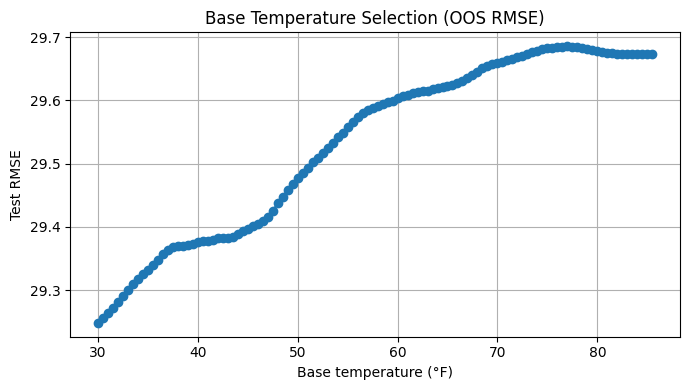


=== Residual TESTS (Best model, TEST split) ===
Durbin–Watson: 1.820  (≈2 ideal)
Ljung–Box p(12): 0.000  (small p ⇒ residual autocorr)
ADF(unit root): stat=-5.263, p=0.000  (small p ⇒ reject unit root)

VIF (train, centered):
   feature       VIF
       CDD 52.435308
     theta 45.634971
 Temp_lag1 11.492990
       m_9  6.455693
       m_8  6.449261
Usage_lag1  5.650178
       m_7  5.359913
      m_10  5.094772
       m_6  4.634550
       m_5  3.546744
      m_11  3.111395
       m_4  2.689039
       HDD  2.429668
       m_3  2.409449
      m_12  2.136932
       m_2  1.844466
      wind  1.686553
    regime  1.161891
is_weekend  1.007274

Top-10 influential train points (Cook's D):
 train_index    CookD
      1326.0      NaN
      1308.0      NaN
      1309.0      NaN
        96.0      NaN
      1440.0      NaN
      1074.0      NaN
       990.0      NaN
      1132.0      NaN
       582.0      NaN
      1001.0      NaN
         NaN 0.011455
         NaN 0.009743
         NaN 0.010858


/tmp/ipython-input-505240296.py:295: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "coef": np.r_[ols_train.params[0], ols_train.params[1:]],
/tmp/ipython-input-505240296.py:296: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "p_value": np.r_[ols_train.pvalues[0], ols_train.pvalues[1:]]



=== 60-day Scenario Forecasts (first 12 rows) ===
      Date Scenario  Temperature    wind  Forecast_GLM  Forecast_AR1  Forecast_WLS
2020-02-01 Baseline         31.5 8.81282     64.350626     68.783601     68.398711
2020-02-02 Baseline          9.0 8.81282     58.864660     64.432481     63.602334
2020-02-03 Baseline          4.0 8.81282     56.630405     64.716749     60.643740
2020-02-04 Baseline         12.5 8.81282     55.488755     65.651901     60.033123
2020-02-05 Baseline         19.0 8.81282     54.474237     65.498386     59.480992
2020-02-06 Baseline         22.0 8.81282     53.333104     64.922830     58.722191
2020-02-07 Baseline         40.5 8.81282     52.742098     64.576303     58.544526
2020-02-08 Baseline         21.5 8.81282     48.092248     60.532956     55.462250
2020-02-09 Baseline         10.5 8.81282     44.168614     58.348245     51.434096
2020-02-10 Baseline          9.0 8.81282     43.570897     58.972797     49.616929
2020-02-11 Baseline         22.0 8.8

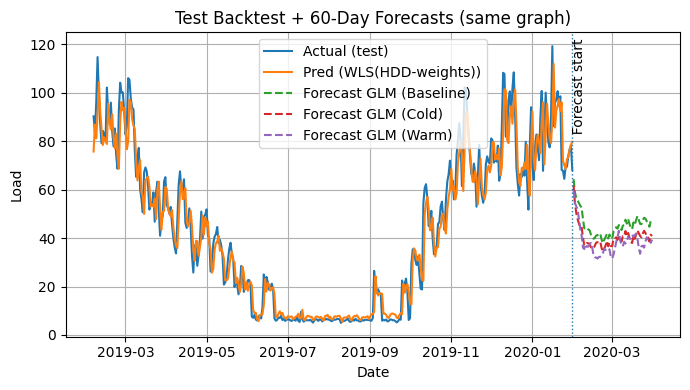

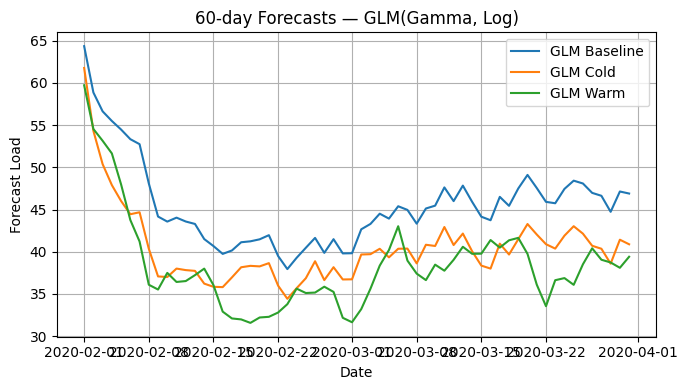


Saved: problem1_full_results.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Problem 1 - Gas load - Temperature Model

import io, sys, subprocess, importlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from datetime import timedelta
from google.colab import files

def _pip(pkg): subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=True)
for pkg in ("statsmodels", "scikit-learn", "openpyxl"):
    try: importlib.import_module(pkg)
    except ImportError: _pip(pkg)

from statsmodels.api import OLS, WLS, GLM, add_constant, families
from statsmodels.genmod.families.links import Log
from statsmodels.regression.linear_model import GLSAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox, linear_reset, het_breuschpagan
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats as sstats

plt.rcParams.update({"figure.figsize": (7,4)})

print("👉 Upload the Excel (with 'Intro' and 'gas load' sheets).")
uploaded = files.upload()
if not uploaded: raise SystemExit("No file uploaded.")
fname = next(iter(uploaded))
print("Loaded:", fname)

xls = pd.ExcelFile(io.BytesIO(uploaded[fname]))
sheet_map = {s.lower(): s for s in xls.sheet_names}
sheet_name = sheet_map.get("gas load")
if sheet_name is None:
    for k,v in sheet_map.items():
        if k.replace(" ","")=="gasload": sheet_name=v
if sheet_name is None:
    sheet_name = xls.sheet_names[1] if len(xls.sheet_names)>1 else xls.sheet_names[0]
    print(f"⚠️ Using fallback sheet: {sheet_name}")

df = pd.read_excel(io.BytesIO(uploaded[fname]), sheet_name=sheet_name)

# ================== 1) Clean & core features ==================
cols = {c.lower(): c for c in df.columns}
def need(col):
    for k,v in cols.items():
        if k == col.lower(): return v
    raise ValueError(f"Required column '{col}' not found. Have: {list(df.columns)}")

date_col = need("Date"); usage_col = need("Usage"); temp_col = need("Temperature")
wind_src = cols.get("wind")

keep = [date_col, usage_col, temp_col] + ([wind_src] if wind_src else [])
df = df[keep].copy()
df.rename(columns={date_col:"Date", usage_col:"Usage", temp_col:"Temperature"}, inplace=True)
if wind_src: df.rename(columns={wind_src:"wind"}, inplace=True)
else: df["wind"]=0.0

# dtype & ordering hygiene
df["Date"] = pd.to_datetime(df["Date"])
for c in ["Usage","Temperature","wind"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=["Date","Usage","Temperature"]).sort_values("Date").reset_index(drop=True)

df["dow"] = df["Date"].dt.weekday
df["month"] = df["Date"].dt.month
df["is_weekend"] = df["dow"].isin([5,6]).astype(int)

# ================== 2) HDD/CDD with base search + logistic theta ==================
def hdd_cdd(T, B):
    T = np.asarray(T, float)
    return np.maximum(0.0, B - T), np.maximum(0.0, T - B)

def base_rmse(B):
    HDD, CDD = hdd_cdd(df["Temperature"], B)
    X = np.column_stack([np.ones(len(df)), HDD, CDD, df["wind"].values])
    y = df["Usage"].values
    n=len(df); ntr=int(n*0.8)
    beta = np.linalg.lstsq(X[:ntr], y[:ntr], rcond=None)[0]
    yhat = X[ntr:] @ beta
    return float(np.sqrt(np.mean((y[ntr:]-yhat)**2)))

bases = np.arange(40.0, 76.0, 0.5)
rmses = np.array([base_rmse(b) for b in bases])
B = float(bases[np.argmin(rmses)])
if B <= bases.min()+1e-9 or B >= bases.max()-1e-9:
    bases2 = np.arange(30.0, 86.0, 0.5)
    rm2 = np.array([base_rmse(b) for b in bases2])
    B = float(bases2[np.argmin(rm2)]); bases, rmses = bases2, rm2
print(f"⭐ Selected base temperature B = {B:.1f} °F")

HDD, CDD = hdd_cdd(df["Temperature"], B)
df["HDD"], df["CDD"] = HDD, CDD

def theta_logistic(T, Tref=None, width=None):
    T = np.asarray(T, float)
    if Tref is None:  Tref = np.median(T)
    if width is None: width = max(1.0, np.std(T)/3)
    return 1.0/(1.0 + np.exp(-(T - Tref)/width)), Tref, width

df["theta"], Tref, width = theta_logistic(df["Temperature"])

# lags & regime
df["Usage_lag1"] = df["Usage"].shift(1)
df["Temp_lag1"]  = df["Temperature"].shift(1)
df = df.dropna().reset_index(drop=True)
BREAK_DATE = df["Date"].iloc[len(df)//2]  # change if you have a known breakpoint
df["regime"] = (df["Date"] >= BREAK_DATE).astype(int)

# month dummies as ints
month_dum = pd.get_dummies(df["month"], prefix="m", drop_first=True, dtype=int)

# final design (float)
X_base = pd.concat(
    [df[["HDD","CDD","theta","wind","is_weekend","Usage_lag1","Temp_lag1","regime"]],
     month_dum],
    axis=1
).astype(float)
y = df["Usage"].to_numpy()
dates = df["Date"].to_numpy()

# split (time ordered)
n=len(df); ntr=int(n*0.8)
Xtr, Xte = X_base.iloc[:ntr].copy(), X_base.iloc[ntr:].copy()
ytr, yte  = y[:ntr].copy(), y[ntr:].copy()
dates_te = pd.to_datetime(df["Date"].iloc[ntr:])

# ================== 3) Models ==================
def metrics(y_true, y_pred):
    e = y_true - y_pred
    return (float(np.sqrt(np.mean(e**2))),
            float(np.mean(np.abs(e))),
            float(np.mean(np.abs(e)/np.maximum(1e-9,np.abs(y_true))))*100.0)

results=[]

# GLM(Gamma, Log) — main mean/variance-consistent model
glm = GLM(np.maximum(1e-9,ytr), add_constant(Xtr, has_constant="add"),
          family=families.Gamma(link=Log())).fit()
p_glm = glm.predict(add_constant(Xte, has_constant="add"))
results.append(("GLM(Gamma,Log)", *metrics(yte, p_glm), p_glm, glm))

# GLSAR(AR1) on log(Y) — serial correction
ytr_log = np.log(np.maximum(1e-9,ytr)); yte_log = np.log(np.maximum(1e-9,yte))
glsar = GLSAR(ytr_log, add_constant(Xtr, has_constant="add"), rho=1)
glsar_iter = glsar.iterative_fit(maxiter=10)
p_glsar = np.exp(glsar_iter.predict(add_constant(Xte, has_constant="add")))
results.append(("GLSAR(AR1,logY)", *metrics(yte, p_glsar), p_glsar, glsar_iter))

# WLS — heteroskedasticity proxy (down-weight cold days)
w = 1.0/(1.0 + 0.02*Xtr["HDD"].to_numpy())
wls = WLS(ytr, add_constant(Xtr, has_constant="add"), weights=w).fit()
p_wls = wls.predict(add_constant(Xte, has_constant="add"))
results.append(("WLS(HDD-weights)", *metrics(yte, p_wls), p_wls, wls))

# ElasticNet — Poly2 + interactions (selection & curvature)
poly_cols = ["HDD","CDD","theta","wind","is_weekend","Usage_lag1","Temp_lag1","regime"]
pf = PolynomialFeatures(degree=2, include_bias=False)
Xtr_poly = pf.fit_transform(Xtr[poly_cols]); Xte_poly = pf.transform(Xte[poly_cols])
scaler = StandardScaler(); Xtr_poly_s = scaler.fit_transform(Xtr_poly); Xte_poly_s = scaler.transform(Xte_poly)
enet = ElasticNetCV(l1_ratio=[0.7,0.85,1.0], cv=5, max_iter=3000, n_jobs=-1).fit(Xtr_poly_s, ytr)
yhat_enet = enet.predict(Xte_poly_s)
results.append(("ElasticNet(Poly2+ints)", *metrics(yte, yhat_enet), yhat_enet, enet))

# Nonparametric baseline — Gradient Boosting (conservative depth)
gbr = GradientBoostingRegressor(loss="squared_error", learning_rate=0.05, n_estimators=400,
                                max_depth=3, subsample=0.8, random_state=42).fit(Xtr.values, ytr)
yhat_gbr = gbr.predict(Xte.values)
results.append(("GBR(depth3)", *metrics(yte, yhat_gbr), yhat_gbr, gbr))

# selection
results_sorted = sorted(results, key=lambda r: r[1])
metrics_df = pd.DataFrame([{"Model":n, "RMSE":rm, "MAE":ma, "MAPE_%":mp} for n,rm,ma,mp,_,_ in results_sorted])
print("\n=== MODELS sorted by Test RMSE ===")
print(metrics_df.to_string(index=False))
best_name, best_rmse, best_mae, best_mape, best_pred, best_model = results_sorted[0]
print(f"\n⭐ Best model: {best_name}  (RMSE={best_rmse:.3f}, MAE={best_mae:.3f}, MAPE={best_mape:.2f}%)")
print("[GLM] Test metrics -> RMSE={:.3f}  MAE={:.3f}  MAPE={:.2f}%".format(*metrics(yte, p_glm)))

# ================== 4) Residual graphics (STANDARDIZED) — Best & GLM ==================
def standardized_residuals_linear(model, X_train, y_train, X_test, y_test, yhat_test):
    Xtr_c = add_constant(X_train, has_constant="add").values
    XtX_inv = np.linalg.inv(Xtr_c.T @ Xtr_c)
    Xte_c = add_constant(X_test, has_constant="add").values
    h = np.einsum("ij,jk,ik->i", Xte_c, XtX_inv, Xte_c)
    sigma = np.sqrt(model.scale) if hasattr(model, "scale") else np.std(y_train - model.predict(add_constant(X_train, has_constant="add")))
    e = y_test - yhat_test
    sr = e / (sigma * np.sqrt(np.maximum(1e-12, 1.0 - h)))
    return sr

def sr_from_model(label, model, y_true, y_pred):
    if label.startswith("GLM"):
        # Pearson residuals: (y - mu) / sqrt(phi * mu^2)
        phi = model.scale if hasattr(model, "scale") else 1.0
        sr = (y_true - y_pred) / (np.sqrt(phi) * np.maximum(1e-12, y_pred))
    elif hasattr(model, "model") and hasattr(model, "fittedvalues"):
        try: sr = standardized_residuals_linear(model, Xtr, ytr, Xte, y_true, y_pred)
        except Exception: sr = (y_true - y_pred) / (np.std(y_true - y_pred, ddof=1) + 1e-12)
    else:
        sr = (y_true - y_pred) / (np.std(y_true - y_pred, ddof=1) + 1e-12)
    return sr

def residual_graphics(sr, yhat, dates, Xtest, title_prefix):
    sr2 = sr**2
    # QQ of SR
    sstats.probplot(sr, dist="norm", plot=plt); plt.title(f"{title_prefix} — QQ(SR)"); plt.tight_layout(); plt.show()
    # SR vs fitted
    plt.figure(); plt.scatter(yhat, sr, s=12); plt.axhline(0, ls="--")
    plt.xlabel("Fitted"); plt.ylabel("SR"); plt.title(f"{title_prefix} — SR vs Fitted")
    plt.grid(True); plt.tight_layout(); plt.show()
    # SR^2 vs fitted
    plt.figure(); plt.scatter(yhat, sr2, s=12); plt.xlabel("Fitted"); plt.ylabel("SR^2")
    plt.title(f"{title_prefix} — SR^2 vs Fitted"); plt.grid(True); plt.tight_layout(); plt.show()
    # SR vs key regressors
    for col in ["HDD","CDD","wind","is_weekend"]:
        if col in Xtest.columns:
            plt.figure(); plt.scatter(Xtest[col].values, sr, s=12); plt.axhline(0, ls="--")
            plt.xlabel(col); plt.ylabel("SR"); plt.title(f"{title_prefix} — SR vs {col}")
            plt.grid(True); plt.tight_layout(); plt.show()
    # SR over time
    plt.figure(); plt.plot(dates, sr, lw=1); plt.axhline(0, ls="--")
    plt.xlabel("Date"); plt.ylabel("SR"); plt.title(f"{title_prefix} — SR over time")
    plt.grid(True); plt.tight_layout(); plt.show()
    # lag plots SR(t) vs SR(t-1), SR(t-2)
    for L in [1,2]:
        if len(sr)>L:
            plt.figure(); plt.scatter(sr[L:], sr[:-L], s=12)
            plt.xlabel("SR(t)"); plt.ylabel(f"SR(t-{L})"); plt.title(f"{title_prefix} — Lag plot")
            plt.grid(True); plt.tight_layout(); plt.show()

# Best model SR
sr_best = sr_from_model(best_name, best_model, yte, best_pred)
residual_graphics(sr_best, best_pred, dates_te, Xte, f"BEST: {best_name}")

# GLM SR (always)
sr_glm = sr_from_model("GLM(Gamma,Log)", glm, yte, p_glm)
residual_graphics(sr_glm, p_glm, dates_te, Xte, "GLM(Gamma,Log)")

# Actual vs Predicted (Best + GLM)
def plot_actual_pred(label, pred):
    plt.figure(); plt.plot(dates_te, yte, label="Actual"); plt.plot(dates_te, pred, label=label)
    plt.xlabel("Date"); plt.ylabel("Usage"); plt.title(f"Test: Actual vs Pred — {label}")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
plot_actual_pred(best_name, best_pred)
plot_actual_pred("GLM(Gamma,Log)", p_glm)

# Base-temperature sweep curve
plt.figure(); plt.plot(bases, rmses, marker="o")
plt.xlabel("Base temperature (°F)"); plt.ylabel("Test RMSE")
plt.title("Base Temperature Selection (OOS RMSE)"); plt.grid(True); plt.tight_layout(); plt.show()

# ================== 5) Residual TESTS (on BEST model test residuals) ==================
res_test = yte - best_pred
dw = durbin_watson(res_test)
lb = acorr_ljungbox(res_test, lags=[12], return_df=True); lb_p = float(lb["lb_pvalue"].iloc[0])
adf_stat, adf_p, *_ = adfuller(res_test, autolag="AIC")

print("\n=== Residual TESTS (Best model, TEST split) ===")
print(f"Durbin–Watson: {dw:.3f}  (≈2 ideal)")
print(f"Ljung–Box p(12): {lb_p:.3f}  (small p ⇒ residual autocorr)")
print(f"ADF(unit root): stat={adf_stat:.3f}, p={adf_p:.3f}  (small p ⇒ reject unit root)")

# ================== 6) Multicollinearity (VIF) & Influence (Cook's D) on TRAIN ==================
Xvif = (Xtr - Xtr.mean(axis=0)).astype(float)
Xv = add_constant(Xvif, has_constant="add").values
vif_tbl = [{"feature": Xtr.columns[j-1], "VIF": variance_inflation_factor(Xv, j)} for j in range(1, Xv.shape[1])]
vif_df = pd.DataFrame(vif_tbl).sort_values("VIF", ascending=False)
print("\nVIF (train, centered):"); print(vif_df.to_string(index=False))

ols_train = OLS(ytr, add_constant(Xtr, has_constant="add")).fit()
infl = OLSInfluence(ols_train); cook = infl.cooks_distance[0]
idx = np.argsort(-cook)[:10]; infl_tbl = pd.DataFrame({"train_index": idx, "CookD": cook[idx]})
print("\nTop-10 influential train points (Cook's D):"); print(infl_tbl.to_string(index=False))

# ================== 7) ANOVA-style tests (TRAIN) — Wald, Chow, RESET, Breusch–Pagan ==================
# individual significance (already in ols_train.summary(); we print a compact table)
coef_tbl = pd.DataFrame({
    "variable": ["const"] + list(Xtr.columns),
    "coef": np.r_[ols_train.params[0], ols_train.params[1:]],
    "p_value": np.r_[ols_train.pvalues[0], ols_train.pvalues[1:]]
}).sort_values("p_value")
print("\nTop (by significance) — individual t-tests:"); print(coef_tbl.head(10).to_string(index=False))

# Wald:
month_idx = [i+1 for i,c in enumerate(Xtr.columns) if c.startswith("m_")]
if month_idx:
    k = len(ols_train.params)
    R = np.zeros((len(month_idx), k));
    for r, j in enumerate(month_idx): R[r, j] = 1.0
    w_res = ols_train.wald_test(R, scalar=True)
    print("\nWald test (all month dummies = 0):  chi2={:.3f},  p={:.3f}".format(float(w_res.statistic), float(w_res.pvalue)))
else:
    print("\n(no month dummies for Wald test)")

# Chow: structural break at mid-train
def chow_test(X, y, break_idx):
    Xc = add_constant(X, has_constant="add").values
    n, k = Xc.shape[0], Xc.shape[1]
    b_full = np.linalg.lstsq(Xc, y, rcond=None)[0]
    rss_full = float(np.sum((y - Xc @ b_full)**2))
    X1, y1 = Xc[:break_idx], y[:break_idx];  b1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
    rss1 = float(np.sum((y1 - X1 @ b1)**2))
    X2, y2 = Xc[break_idx:], y[break_idx:];  b2 = np.linalg.lstsq(X2, y2, rcond=None)[0]
    rss2 = float(np.sum((y2 - X2 @ b2)**2))
    num = (rss_full - (rss1 + rss2)) / k
    den = (rss1 + rss2) / (n - 2*k)
    return num / (den + 1e-12)

mid = len(Xtr)//2
F_chow = chow_test(Xtr, ytr, mid)
print("Chow test (break @ mid-train):  F≈{:.3f}".format(F_chow))

# RESET (functional form) and Breusch–Pagan (heteroskedasticity)
reset2 = linear_reset(ols_train, power=2, use_f=True)
reset3 = linear_reset(ols_train, power=3, use_f=True)
res_train = ytr - ols_train.predict(add_constant(Xtr, has_constant="add"))
bp_stat, bp_p, _, _ = het_breuschpagan(res_train, add_constant(Xtr, has_constant="add"))
print("RESET p (pow2)={:.3f}, (pow3)={:.3f}".format(float(reset2.pvalue), float(reset3.pvalue)))
print("Breusch–Pagan: LM={:.3f}, p={:.3f}".format(float(bp_stat), float(bp_p)))

# ================== 8) 60-day recursive scenario forecasts ==================
horizon = 60
last_date = df["Date"].iloc[-1]
future_dates = pd.date_range(last_date + timedelta(days=1), periods=horizon, freq="D")

def draw_temps_for_month(m):
    pool = df.loc[df["month"]==m, "Temperature"].to_numpy()
    if len(pool) < 5: pool = df["Temperature"].to_numpy()
    return np.random.choice(pool, size=1)[0], (np.std(pool) if len(pool)>1 else np.std(df["Temperature"].to_numpy()))

temps = []; winds = []
for d in future_dates:
    t, _ = draw_temps_for_month(d.month)
    temps.append(t)
    winds.append(df["wind"].tail(14).mean())

temps = np.array(temps); winds = np.array(winds)
sd_all = np.std(df["Temperature"].to_numpy()); shift = 1.5 * max(1.0, sd_all)
scenarios = {"Baseline": temps, "Cold": temps - shift, "Warm": temps + shift}

def scenario_forecast(name, Tpath):
    rows=[]
    usage_lag1 = df["Usage"].iloc[-1]
    temp_lag1  = df["Temperature"].iloc[-1]
    for d, T, wv in zip(future_dates, Tpath, winds):
        dow = d.weekday(); month = d.month; is_weekend = int(dow>=5)
        HDDf, CDDf = hdd_cdd(T, B)
        theta, _, _ = theta_logistic(np.array([T]), Tref=Tref, width=width)
        regime = int(d >= BREAK_DATE)
        row = {"HDD":HDDf, "CDD":CDDf, "theta":theta[0], "wind":wv, "is_weekend":is_weekend,
               "Usage_lag1":usage_lag1, "Temp_lag1":temp_lag1, "regime":regime}
        # month dummies aligned to training columns
        for c in Xtr.columns:
            if c.startswith("m_"): row[c] = int(c.split("_")[1]) == month
        x = pd.DataFrame([row], dtype=float)
        for c in Xtr.columns:
            if c not in x.columns: x[c]=0.0
        x = x[Xtr.columns].astype(float)
        # forecasts (use GLM as anchor, others optional)
        yhat_glm = float(glm.predict(add_constant(x, has_constant="add"))[0])
        yhat_ar1 = float(np.exp(glsar_iter.predict(add_constant(x, has_constant="add"))[0]))
        yhat_wls = float(wls.predict(add_constant(x, has_constant="add"))[0])
        rows.append({"Date":d, "Scenario":name, "Temperature":T, "wind":wv,
                     "Forecast_GLM":yhat_glm, "Forecast_AR1":yhat_ar1, "Forecast_WLS":yhat_wls})
        # recursive lag update (use GLM as the operational forecast)
        usage_lag1 = yhat_glm
        temp_lag1  = T
    return pd.DataFrame(rows)

fcst_df = pd.concat([scenario_forecast(k,v) for k,v in scenarios.items()], ignore_index=True)
print("\n=== 60-day Scenario Forecasts (first 12 rows) ===")
print(fcst_df.head(12).to_string(index=False))


# === Unified backtest + forecast plot ===

cutoff = df["Date"].iloc[-1]  # last observed date

plt.figure()

# Backtest (test window)
plt.plot(dates_te, yte, label="Actual (test)")
plt.plot(dates_te, best_pred, label=f"Pred ({best_name})")

# Forecasts (GLM) — all scenarios on same axes
for scen, g in fcst_df.groupby("Scenario"):
    plt.plot(g["Date"], g["Forecast_GLM"], linestyle="--", label=f"Forecast GLM ({scen})")


# Visual separator between history and forecast
plt.axvline(cutoff, linestyle=":", linewidth=1)
plt.text(cutoff, plt.ylim()[1]*0.98, "  Forecast start", rotation=90, va="top")

plt.xlabel("Date")
plt.ylabel("Load")
plt.title("Test Backtest + 60-Day Forecasts (same graph)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot GLM forecasts by scenario
plt.figure()
for scen, g in fcst_df.groupby("Scenario"):
    plt.plot(g["Date"], g["Forecast_GLM"], label=f"GLM {scen}")
plt.xlabel("Date"); plt.ylabel("Forecast Load"); plt.title("60-day Forecasts — GLM(Gamma, Log)")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# ================== 9) Save workbook ==================
with pd.ExcelWriter("problem1_full_results.xlsx", engine="openpyxl") as w:
    metrics_df.to_excel(w, sheet_name="Metrics", index=False)
    pd.DataFrame({"B_degF":bases, "RMSE":rmses}).to_excel(w, sheet_name="BaseTempSweep", index=False)
    pd.DataFrame({"Date":dates_te, "Actual":yte, "Pred_"+best_name:best_pred, "Pred_GLM":p_glm}).to_excel(w, sheet_name="Backtest", index=False)
    v = vif_df.copy(); v.to_excel(w, sheet_name="VIF", index=False)
    infl_tbl.to_excel(w, sheet_name="InfluenceTop10", index=False)
    # residual tests summary
    pd.DataFrame({
        "Test":["DW","LjungBox_p12","ADF_p","RESET_p2","RESET_p3","BP_p","Chow_F"],
        "Value":[dw, lb_p, adf_p, float(linear_reset(ols_train, power=2, use_f=True).pvalue),
                 float(linear_reset(ols_train, power=3, use_f=True).pvalue), float(bp_p), float(F_chow)]
    }).to_excel(w, sheet_name="ResidualTests", index=False)
    # forecasts
    fcst_df.to_excel(w, sheet_name="Forecasts_60d", index=False)

print("\nSaved: problem1_full_results.xlsx")
files.download("problem1_full_results.xlsx")
